In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=200)

In [ ]:
# Generates d independent Brownian motions of size n with drift, volatility
def brownian_motion(steps, n, mu, sigma, dt=1):
    """
    Parameters:
        steps (int): Number of time steps.
        n (int): Number of independent Brownian motions.
        mu (float): Drift term (default is 0).
        sigma (float): Volatility term (default is 1).
        dt (float): Time step size (default is 1).
    """
    mu = np.asarray(mu).reshape(n, 1)      # Ensure mu is (n,1) for broadcasting
    sigma = np.asarray(sigma).reshape(n, 1) # Ensure sigma is (n,1) for broadcasting

    dW = np.sqrt(dt) * np.random.randn(n, steps)  # Standard Brownian increments
    W = np.cumsum(sigma * dW, axis=1)  # Scale by volatility and integrate
    t = np.arange(1, steps + 1) * dt  # Time steps
    drift = mu * t  # Linear drift component

    return W + drift  # Add drift

In [ ]:
def replace_diagonal_with_minus_one(matrix):
        np.fill_diagonal(matrix, -1)
        return matrix

In [ ]:
# Update wealth based on Brownian motion.
def update_wealth(wealth, bm_vector):
    """
    Parameters:
        wealth (numpy.ndarray): Vector of wealth for each player.
        bm_vector (numpy.ndarray): Brownian motion vector (n x steps).
    """
    return wealth * (1 + bm_vector[:, -1])

In [ ]:
def topk_with_forced_index(prob_vector, i):
    n = len(prob_vector)
    k = max(5, int(np.ceil(n / 100)))

    # Get indices of top-k values
    topk_indices = np.argpartition(prob_vector, -k)[-k:]

    # Create filtered vector
    filtered = np.zeros_like(prob_vector)
    filtered[topk_indices] = prob_vector[topk_indices]

    # Renormalize
    total = np.sum(filtered)
    if total > 0:
        filtered /= total

    return filtered

In [ ]:
def copyingProbability(wealth, bm_vector, alpha, beta):
    n = len(wealth)  # Number of players
    probability_matrix = np.zeros((n, n))  # Initialize the probability matrix
    wealth_norm = wealth / np.sum(wealth)

    for i in range(n):
        probability_vec = np.zeros(n)  # Initialize the probability vector for player i

        for j in range(n):
            # Compute the probability for player i comparing with player j
            diff_bm = bm_vector[j].item() - bm_vector[i].item()  # Difference in final BM values
            diff_wealth = wealth_norm[j].item() - wealth_norm[i].item()  # Difference in wealth values

            # Formula for probability
            probability_vec[j] = alpha * diff_bm + beta * diff_wealth

        # Clip values in the probability vector to 0 if less than 0
        probability_vec = np.clip(probability_vec, 0, None)

        # Calculate the total: sum of vector + number of zeros in the vector
        zero_count =  np.count_nonzero(probability_vec == 0)
        probability_vec[i] = zero_count / n
        total = np.sum(probability_vec)

        # Normalize the vector based on the total
        if total > 0:  # Avoid division by zero
            probability_vec /= total

        probability_vec = topk_with_forced_index(probability_vec, i)

        # Update the probability matrix
        probability_matrix[i, :] = probability_vec

    return probability_matrix

In [ ]:
def networkInitial(n, wealth):
    # Create graph
    G = nx.DiGraph()

    # Add nodes
    G.add_nodes_from(range(n))

    # Positioning (spring layout for better spacing)
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 10))  # Increase figure size

    # Draw nodes with size based on wealth
    nx.draw_networkx_nodes(G, pos, node_size=wealth, node_color='white', edgecolors='black', linewidths=0.5)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

    plt.title("Initial Network Graph with Node Sizes Based on Wealth")
    plt.show()

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def networkMaker(n, weightEdges, performanceVector, iterationCount, alpha, beta):
    # Create directed graph
    G = nx.DiGraph()
    G.add_nodes_from(range(n))
    threshold = 0

    # Add edges with weights
    for i in range(n):
        for j in range(n):
            if i != j and weightEdges[i, j] > threshold:
                G.add_edge(i, j, weight=weightEdges[i, j])

    performanceVector = np.array(performanceVector).flatten()
    performanceVector = np.clip(performanceVector, None, 1)
    wealth_norm = wealth / np.sum(wealth)

    # Compute positions: radial layout with high-performance nodes near center
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    combined_score = alpha * performanceVector + beta * wealth_norm
    combined_score = (combined_score - combined_score.min()) / (combined_score.max() - combined_score.min())

    NODE_SIZE_MULTIPLIER = 40000  # Adjust this value to control node sizes
    node_sizes = NODE_SIZE_MULTIPLIER * wealth_norm

    radii = 0.5 + (1.0 - combined_score)  # radius now ranges from 0.5 to 1.5

    pos = {
        i: (radii[i] * np.cos(angles[i]), radii[i] * np.sin(angles[i]))
        for i in range(n)
    }

    # Node coloring based on bm_vector
    node_colors = [
        (1 - abs(bm), 1, 1 - abs(bm)) if bm > 0 else (1, 1 - abs(bm), 1 - abs(bm))
        for bm in performanceVector
    ]  # Green for positive, red for negative

    plt.figure(figsize=(14, 14))

    # Draw nodes with custom colors
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='black', linewidths=0.5)

    # Edge properties
    edges = G.edges(data=True)
    edge_weights = np.array([d['weight'] for (u, v, d) in edges])
    edge_colors = edge_weights / edge_weights.max() if edge_weights.max() > 0 else edge_weights

    # Draw edges
    nx.draw_networkx_edges(
        G, pos, edgelist=edges, width=[w * 5 for w in edge_weights],
        alpha=0.7, edge_color=edge_colors,
        edge_cmap=plt.cm.Blues, edge_vmin=0, edge_vmax=1
    )

    # Labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    # Colorbar for edge weights
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), label="Edge Weight Intensity", fraction=0.028, pad=0.06)

    plt.title("Weighted Network Graph at t = " + str(iterationCount + 1))
    plt.axis('off')

    # Normalize performanceVector for color mapping
    norm_perf = plt.Normalize(vmin=performanceVector.min(), vmax=performanceVector.max())
    sm_nodes = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=norm_perf)
    sm_nodes.set_array([])


    # Colorbar for node performance
    cbar_nodes = plt.colorbar(sm_nodes, ax=plt.gca(), fraction=0.03, pad=0.04)
    cbar_nodes.set_label("Node Performance")

    plt.show()

In [ ]:
def process_time_step_n(prob_matrix, performanceVec, wealth, alpha, beta):

    system = replace_diagonal_with_minus_one(prob_matrix)

    # Creates the b vector
    diag_elements = np.diag(prob_matrix)
    RHS = diag_elements * performanceVec.ravel() * -1

    # Solves the system and applies it to prob_matrix
    v = np.linalg.solve(system, RHS)
    phase2 = np.matmul(prob_matrix, v)

    # Updates everything
    wealth = update_wealth(wealth, phase2.reshape(n, 1))
    prob_matrix = copyingProbability(wealth, phase2, alpha, beta)

    return wealth, prob_matrix

In [ ]:
n = 50 # Number of players

# Parameters for capital per person
wealth =  np.random.randint(low = 250, high = 1000, size=n)

# Paramets for drfit
low = -0.5
high = 0.5
mu = np.random.uniform(low, high, size=n)

# Vector for volatility
low = 0.1
high = 0.2
sigma = np.random.uniform(low, high, size=n)

# networkInitial(n, wealth) # 0 Time step
alpha = 1 # Performance weight parameter
beta = 0 # Wealth weight parameter
steps = 1000  # Number of time steps

In [ ]:
wealth =  np.random.randint(low = 250, high = 1000, size=n)
# networkInitial(n, wealth) # 0 Time step
alpha = 1 # Performance weight parameter
beta = 0 # Wealth weight parameter
steps = 1000  # Number of time steps

for i in range(steps):
  if i == 0:
    bm_vector = brownian_motion(1, n, mu, sigma)
    bm_vector = np.clip(bm_vector, -0.90, None) # Government intervention

    wealth = update_wealth(wealth, bm_vector)
    prob_matrix = copyingProbability(wealth, bm_vector, alpha , beta)

  else:
    bm_vector = brownian_motion(1, n, mu, sigma)
    bm_vector = np.clip(bm_vector, -0.90, None) # Government intervention
    wealth, prob_matrix = process_time_step_n(prob_matrix, bm_vector, wealth, alpha , beta)
    if i in {0, 24, 49, 99, 499, 999}:
      column_sums = prob_matrix.sum(axis=0)
      rounded_sums = np.round(column_sums, 3)
      for idx, val in enumerate(rounded_sums):
        print(f"Node {idx}: {val}")


  if i in {0, 24, 49, 99, 499, 999}:
    networkMaker(n, prob_matrix, bm_vector, i, alpha, beta)

In [ ]:
wealth =  np.random.randint(low = 250, high = 1000, size=n)
# networkInitial(n, wealth) # 0 Time step
alpha = 1 # Performance weight parameter
beta = 1 # Wealth weight parameter
steps = 1000  # Number of time steps

for i in range(steps):
  if i == 0:
    bm_vector = brownian_motion(1, n, mu, sigma)
    bm_vector = np.clip(bm_vector, -0.90, None) # Government intervention

    wealth = update_wealth(wealth, bm_vector)
    prob_matrix = copyingProbability(wealth, bm_vector, alpha , beta)

  else:
    bm_vector = brownian_motion(1, n, mu, sigma)
    bm_vector = np.clip(bm_vector, -0.90, None) # Government intervention
    wealth, prob_matrix = process_time_step_n(prob_matrix, bm_vector, wealth, alpha , beta)
    if i in {0, 24, 49, 99, 499, 999}:
      column_sums = prob_matrix.sum(axis=0)
      rounded_sums = np.round(column_sums, 3)
      for idx, val in enumerate(rounded_sums):
        print(f"Node {idx}: {val}")


  if i in {0, 24, 49, 99, 499, 999}:
    networkMaker(n, prob_matrix, bm_vector, i, alpha, beta)

In [ ]:
wealth =  np.random.randint(low = 250, high = 1000, size=n)
# networkInitial(n, wealth) # 0 Time step
alpha = 1 # Performance weight parameter
beta = 2 # Wealth weight parameter
steps = 1000  # Number of time steps

for i in range(steps):
  if i == 0:
    bm_vector = brownian_motion(1, n, mu, sigma)
    bm_vector = np.clip(bm_vector, -0.90, None) # Government intervention

    wealth = update_wealth(wealth, bm_vector)
    prob_matrix = copyingProbability(wealth, bm_vector, alpha , beta)

  else:
    bm_vector = brownian_motion(1, n, mu, sigma)
    bm_vector = np.clip(bm_vector, -0.90, None) # Government intervention
    wealth, prob_matrix = process_time_step_n(prob_matrix, bm_vector, wealth, alpha , beta)
    if i in {0, 24, 49, 99, 499, 999}:
      column_sums = prob_matrix.sum(axis=0)
      rounded_sums = np.round(column_sums, 3)
      for idx, val in enumerate(rounded_sums):
        print(f"Node {idx}: {val}")


  if i in {0, 24, 49, 99, 499, 999}:
    networkMaker(n, prob_matrix, bm_vector, i, alpha, beta)

In [ ]:
drift = np.round(mu, 4)

idMax = np.argmax(drift)
valMAX = drift[idMax]

print(f"Argmax index: {idMax}, Value: {valMAX}")

# Mask the max value so it's not considered, for second max
masked = drift.copy()
masked[idMax] = -np.inf  # or a very small number if negatives are valid in your data
# Get the index and value of the second max
second_idx = np.argmax(masked)
second_val = drift[second_idx]
print(f"Second max index: {second_idx}, Value: {second_val}")

for idx, val in enumerate(drift):
  print(f"Node {idx}: {val}")

Argmax index: 19, Value: 0.4877
Second max index: 34, Value: 0.4759
Node 0: -0.2392
Node 1: -0.2097
Node 2: -0.0034
Node 3: 0.4632
Node 4: 0.4727
Node 5: 0.3992
Node 6: -0.0562
Node 7: -0.278
Node 8: -0.3471
Node 9: -0.0332
Node 10: 0.0978
Node 11: -0.1421
Node 12: 0.234
Node 13: -0.0657
Node 14: 0.0851
Node 15: -0.4188
Node 16: -0.3111
Node 17: -0.2866
Node 18: -0.0622
Node 19: 0.4877
Node 20: 0.3968
Node 21: -0.1721
Node 22: -0.0721
Node 23: -0.182
Node 24: -0.3767
Node 25: -0.0711
Node 26: -0.0623
Node 27: 0.3509
Node 28: -0.2988
Node 29: -0.2476
Node 30: 0.0625
Node 31: -0.3273
Node 32: -0.4939
Node 33: 0.2984
Node 34: 0.4759
Node 35: -0.3367
Node 36: -0.3255
Node 37: 0.1088
Node 38: -0.4265
Node 39: 0.0604
Node 40: 0.0127
Node 41: 0.3307
Node 42: -0.4634
Node 43: -0.291
Node 44: -0.356
Node 45: 0.273
Node 46: 0.4135
Node 47: -0.3294
Node 48: 0.295
Node 49: -0.2778


In [ ]:
influences = []
wealth = np.random.randint(low=250, high=1000, size=n)
alpha = 1
beta = 500

for i in range(steps):
    bm_vector = brownian_motion(1, n, mu, sigma)
    bm_vector = np.clip(bm_vector, -0.90, None)

    if i == 0:
        wealth = update_wealth(wealth, bm_vector)
        prob_matrix = copyingProbability(wealth, bm_vector, alpha, beta)
    else:
        wealth, prob_matrix = process_time_step_n(prob_matrix, bm_vector, wealth, alpha, beta)

    # Efficient influence tracking
    column_sums = prob_matrix.sum(axis=0)
    idMax = np.argmax(column_sums)
    influence = column_sums[idMax] / n
    influences.append(influence)

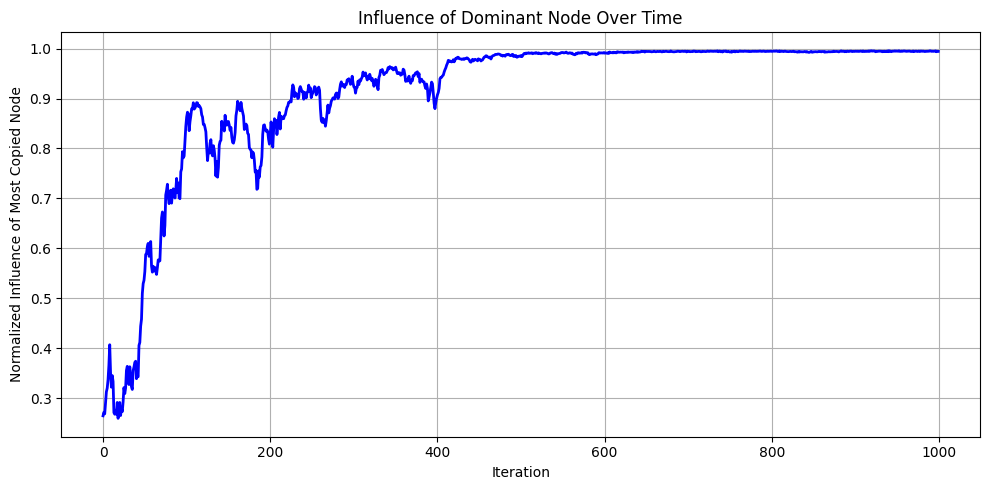

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(steps), influences, color='blue', linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Normalized Influence of Most Copied Node")
plt.title("Influence of Dominant Node Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()